# Local Structure Learning in an Ising Model (Clean Run): PLL vs Interaction Screening with Top-$E$ Selection

This is a **clean, linear** version of the experiment (no out-of-order execution pitfalls).

We simulate a small Ising model on a **4×4 grid** (N=16, **E=24 edges**), then:

1. Sample data with Gibbs sampling.
2. Stage 1: learn structure using
   - PLL (node-wise logistic regression) + L1
   - Interaction screening surrogate + L1
   and select edges using **Top-E = 24** by symmetrized score.
3. Stage 2: refit weights on the recovered graph with **no L1**.
4. Save figures into `figs/` for LaTeX inclusion.


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)

FIG_DIR = "figs"
os.makedirs(FIG_DIR, exist_ok=True)

def savefig(name, dpi=200):
    path = os.path.join(FIG_DIR, name)
    plt.savefig(path, dpi=dpi, bbox_inches="tight")
    print("saved:", path)

def sigmoid(z):
    return 1.0/(1.0 + np.exp(-z))

In [2]:
# --- Helper functions ---
def symmetrize_scores(W):
    N = W.shape[0]
    S = np.zeros((N, N))
    for i in range(N):
        for j in range(i+1, N):
            Sij = 0.5*(abs(W[i, j]) + abs(W[j, i]))
            S[i, j] = S[j, i] = Sij
    return S

def adjacency_top_k(score, k):
    N = score.shape[0]
    pairs = [(i, j, float(score[i, j])) for i in range(N) for j in range(i+1, N)]
    pairs.sort(key=lambda t: t[2], reverse=True)
    A = np.zeros((N, N), dtype=int)
    for (i, j, _) in pairs[:k]:
        A[i, j] = 1
        A[j, i] = 1
    return A

def prf1(Ahat, Atrue):
    N = Atrue.shape[0]
    tp = fp = fn = 0
    for i in range(N):
        for j in range(i+1, N):
            if Ahat[i, j] == 1 and Atrue[i, j] == 1:
                tp += 1
            elif Ahat[i, j] == 1 and Atrue[i, j] == 0:
                fp += 1
            elif Ahat[i, j] == 0 and Atrue[i, j] == 1:
                fn += 1
    prec = tp / (tp + fp + 1e-12)
    rec  = tp / (tp + fn + 1e-12)
    f1   = 2*prec*rec / (prec + rec + 1e-12)
    return prec, rec, f1, tp, fp, fn

## 1) Graph and Ising parameters

In [3]:
def make_grid_graph(L=4):
    N = L*L
    edges = []
    def idx(r, c): return r*L + c
    for r in range(L):
        for c in range(L):
            i = idx(r, c)
            if r+1 < L:
                edges.append((i, idx(r+1, c)))
            if c+1 < L:
                edges.append((i, idx(r, c+1)))
    return N, edges

def sample_parameters_uniform_signed(N, edges, J0=0.35, h_scale=0.0, seed=1):
    rng = np.random.default_rng(seed)
    J = np.zeros((N, N), dtype=float)
    for (i, j) in edges:
        sgn = rng.choice([-1.0, +1.0])
        J[i, j] = sgn * J0
        J[j, i] = sgn * J0
    h = rng.normal(0.0, h_scale, size=N)
    return J, h


L = 4
N, edges = make_grid_graph(L=L)
E_true = 2*L*(L-1)  # 24 for 4x4 grid

J_true, h_true = sample_parameters_uniform_signed(
    N, edges, J0=0.35, h_scale=0.0, seed=1
)

A_true = (np.abs(J_true) > 1e-12).astype(int)
np.fill_diagonal(A_true, 0)

print("N =", N, "E_true =", E_true, "E_from_J =", A_true.sum()//2)

N = 16 E_true = 24 E_from_J = 24


## 2) Sampling via Gibbs

In [4]:
def gibbs_sample(J, h, n_samples=6000, burn_in=3000, thin=10, seed=2):
    rng = np.random.default_rng(seed)
    N = len(h)
    x = rng.choice([-1, 1], size=N)
    samples = []
    total_steps = burn_in + n_samples*thin
    for t in range(total_steps):
        for i in rng.permutation(N):
            field = h[i] + np.dot(J[i, :], x) - J[i, i]*x[i]
            p_plus = 1.0/(1.0 + np.exp(-2.0*field))
            x[i] = 1 if rng.random() < p_plus else -1
        if t >= burn_in and ((t - burn_in) % thin == 0):
            samples.append(x.copy())
    return np.array(samples, dtype=np.int8)

X = gibbs_sample(J_true, h_true, n_samples=6000, burn_in=3000, thin=10, seed=2)
print("X shape:", X.shape)

X shape: (6000, 16)


saved: figs/ising_empirical_covariance.png


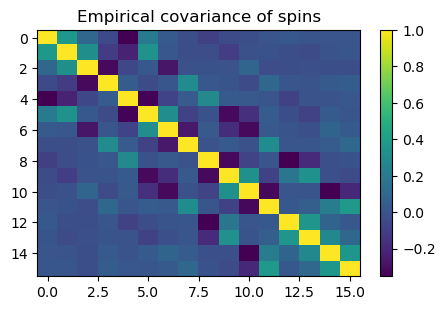

In [5]:
plt.figure(figsize=(5.2, 3.2))
plt.imshow(np.cov(X.T), aspect="auto")
plt.title("Empirical covariance of spins")
plt.colorbar()
savefig("ising_empirical_covariance.png")
plt.show()

## 3) Stage 1A: PLL + L1 (node-wise logistic regression)

saved: figs/pll_l1_loss_trace_node0.png


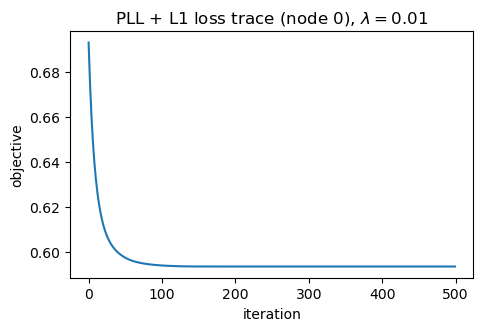

In [6]:
def ista_logistic_l1(X_feat, y_pm1, lam=0.01, max_iter=500, step=0.15):
    S, d = X_feat.shape
    w = np.zeros(d)
    b = 0.0
    losses = []
    for it in range(max_iter):
        z = b + X_feat @ w
        yz = y_pm1 * z
        loss = np.mean(np.log1p(np.exp(-yz))) + lam*np.sum(np.abs(w))
        losses.append(loss)

        s = sigmoid(-yz)              # d/dz log(1+exp(-yz)) = -y*sigma(-yz)
        grad_z = -y_pm1 * s
        grad_w = (X_feat.T @ grad_z)/S
        grad_b = np.mean(grad_z)

        w = w - step*grad_w
        b = b - step*grad_b
        # proximal step for L1
        w = np.sign(w)*np.maximum(0.0, np.abs(w) - step*lam)
    return w, b, np.array(losses)

def fit_pll_all_nodes(X, lam=0.01, max_iter=500, step=0.15):
    S, N = X.shape
    W = np.zeros((N, N))
    b = np.zeros(N)
    traces = []
    for i in range(N):
        feats = np.delete(X, i, axis=1).astype(float)
        y = X[:, i].astype(float)
        w_i, b_i, losses = ista_logistic_l1(feats, y, lam=lam, max_iter=max_iter, step=step)
        full = np.zeros(N)
        full[np.arange(N) != i] = w_i
        W[i, :] = full
        b[i] = b_i
        traces.append(losses)
    return W, b, traces

lam_pll = 0.01
W_pll_l1, b_pll_l1, pll_losses = fit_pll_all_nodes(X, lam=lam_pll, max_iter=500, step=0.15)

plt.figure(figsize=(5.2, 3.2))
plt.plot(pll_losses[0])
plt.title(rf"PLL + L1 loss trace (node 0), $\lambda={lam_pll}$")
plt.xlabel("iteration")
plt.ylabel("objective")
savefig("pll_l1_loss_trace_node0.png")
plt.show()

In [7]:
score_pll = symmetrize_scores(W_pll_l1)
Ahat_pll = adjacency_top_k(score_pll, E_true)
print("PLL top-E:", prf1(Ahat_pll, A_true))

PLL top-E: (0.9999999999999584, 0.9999999999999584, 0.9999999999994584, 24, 0, 0)


## 3) Stage 1B: Interaction Screening surrogate + L1

saved: figs/is_l1_loss_trace_node0.png


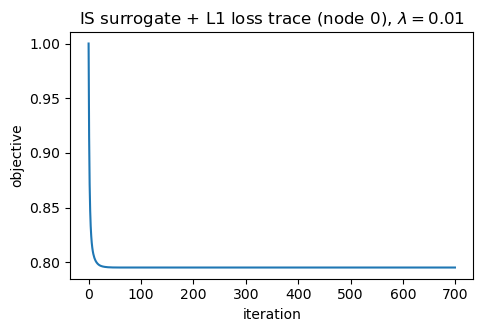

In [8]:
def ista_is_squared(X_feat, y_pm1, lam=0.01, max_iter=700, step=0.08):
    S, d = X_feat.shape
    w = np.zeros(d)
    b = 0.0
    losses = []
    for it in range(max_iter):
        z = b + X_feat @ w
        t = np.tanh(z)
        resid = (t - y_pm1)
        loss = np.mean(resid**2) + lam*np.sum(np.abs(w))
        losses.append(loss)

        dt = (1.0 - t**2)
        grad_z = 2.0*resid*dt
        grad_w = (X_feat.T @ grad_z)/S
        grad_b = np.mean(grad_z)

        w = w - step*grad_w
        b = b - step*grad_b
        w = np.sign(w)*np.maximum(0.0, np.abs(w) - step*lam)
    return w, b, np.array(losses)

def fit_is_all_nodes(X, lam=0.01, max_iter=700, step=0.08):
    S, N = X.shape
    W = np.zeros((N, N))
    b = np.zeros(N)
    traces = []
    for i in range(N):
        feats = np.delete(X, i, axis=1).astype(float)
        y = X[:, i].astype(float)
        w_i, b_i, losses = ista_is_squared(feats, y, lam=lam, max_iter=max_iter, step=step)
        full = np.zeros(N)
        full[np.arange(N) != i] = w_i
        W[i, :] = full
        b[i] = b_i
        traces.append(losses)
    return W, b, traces

lam_is = 0.01
W_is_l1, b_is_l1, is_losses = fit_is_all_nodes(X, lam=lam_is, max_iter=700, step=0.08)

plt.figure(figsize=(5.2, 3.2))
plt.plot(is_losses[0])
plt.title(rf"IS surrogate + L1 loss trace (node 0), $\lambda={lam_is}$")
plt.xlabel("iteration")
plt.ylabel("objective")
savefig("is_l1_loss_trace_node0.png")
plt.show()

In [9]:
score_is = symmetrize_scores(W_is_l1)
Ahat_is = adjacency_top_k(score_is, E_true)
print("IS  top-E:", prf1(Ahat_is, A_true))

IS  top-E: (0.9999999999999584, 0.9999999999999584, 0.9999999999994584, 24, 0, 0)


## 4) Compare recovered adjacencies

saved: figs/ising_adj_true_pll_is_topE.png


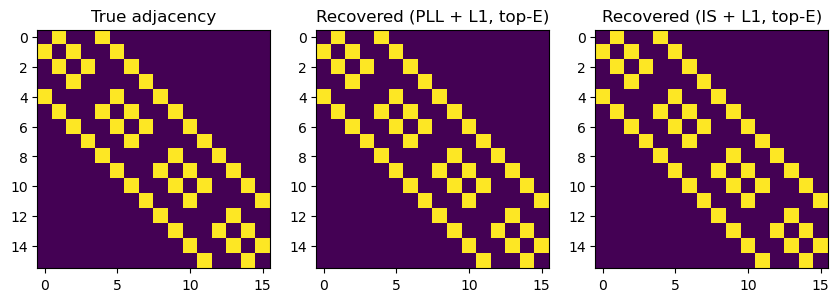

In [10]:
plt.figure(figsize=(10.2, 3.1))
plt.subplot(1,3,1); plt.imshow(A_true, aspect="auto"); plt.title("True adjacency")
plt.subplot(1,3,2); plt.imshow(Ahat_pll, aspect="auto"); plt.title("Recovered (PLL + L1, top-E)")
plt.subplot(1,3,3); plt.imshow(Ahat_is, aspect="auto"); plt.title("Recovered (IS + L1, top-E)")
savefig("ising_adj_true_pll_is_topE.png")
plt.show()

## 5) Stage 2: refit weights on recovered graph (no L1)

saved: figs/pll_refit_loss_trace_node0.png


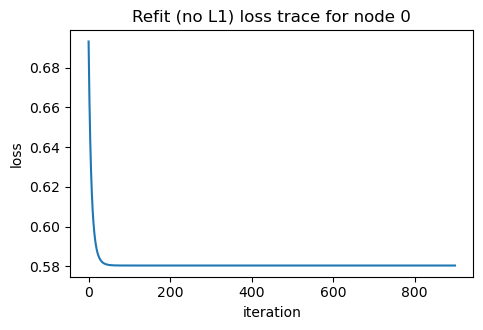

In [12]:
def fit_logistic_unpenalized(X_feat, y_pm1, max_iter=900, step=0.25):
    S, d = X_feat.shape
    w = np.zeros(d)
    b = 0.0
    losses=[]
    for it in range(max_iter):
        z = b + X_feat @ w
        yz = y_pm1 * z
        loss = np.mean(np.log1p(np.exp(-yz)))
        losses.append(loss)
        s = sigmoid(-yz)
        grad_z = -y_pm1 * s
        grad_w = (X_feat.T @ grad_z)/S
        grad_b = np.mean(grad_z)
        w = w - step*grad_w
        b = b - step*grad_b
    return w, b, np.array(losses)

def refit_weights_given_graph_pll(X, Ahat, max_iter=900, step=0.25):
    S, N = X.shape
    W = np.zeros((N,N))
    b = np.zeros(N)
    traces=[]
    for i in range(N):
        neigh = np.where(Ahat[i,:]==1)[0]
        if len(neigh)==0:
            traces.append(np.array([0.0]))
            continue
        X_feat = X[:, neigh].astype(float)
        y = X[:, i].astype(float)
        w_i, b_i, losses = fit_logistic_unpenalized(X_feat, y, max_iter=max_iter, step=step)
        W[i, neigh] = w_i
        b[i]=b_i
        traces.append(losses)
    return W, b, traces

W_pll_refit, b_pll_refit, refit_losses = refit_weights_given_graph_pll(X, Ahat_pll)

plt.figure(figsize=(5.2,3.2))
plt.plot(refit_losses[0])
plt.title("Refit (no L1) loss trace for node 0")
plt.xlabel("iteration")
plt.ylabel("loss")
savefig("pll_refit_loss_trace_node0.png")
plt.show()

In [13]:
W_true = 2.0*J_true

def weight_metrics(W_est, W_true, A_true_support):
    N = W_true.shape[0]
    est=[]; tru=[]
    for i in range(N):
        for j in range(i+1,N):
            if A_true_support[i,j]==1:
                est_ij = 0.5*(W_est[i,j] + W_est[j,i])
                est.append(est_ij)
                tru.append(W_true[i,j])
    est = np.array(est); tru = np.array(tru)
    rmse = np.sqrt(np.mean((est-tru)**2))
    corr = np.corrcoef(est, tru)[0,1]
    return rmse, corr, est, tru

rmse_stage1, corr_stage1, est_stage1, tru = weight_metrics(W_pll_l1, W_true, A_true)
rmse_stage2, corr_stage2, est_stage2, tru2 = weight_metrics(W_pll_refit, W_true, A_true)

print("Stage 1 (PLL+L1) RMSE:", rmse_stage1, "corr:", corr_stage1)
print("Stage 2 (refit)  RMSE:", rmse_stage2, "corr:", corr_stage2)

Stage 1 (PLL+L1) RMSE: 0.07414454172746467 corr: 0.9990717432707096
Stage 2 (refit)  RMSE: 0.028736383618922237 corr: 0.9991828801596117


saved: figs/ising_weight_scatter_stage1_vs_stage2.png


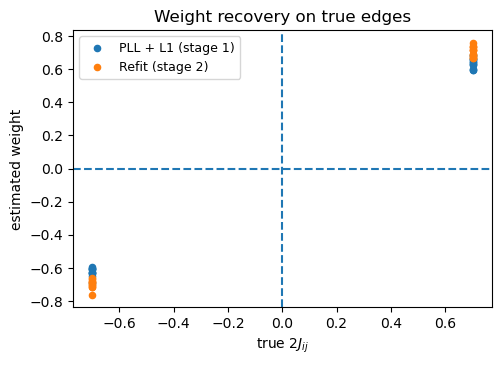

In [14]:
plt.figure(figsize=(5.4,3.6))
plt.scatter(tru, est_stage1, s=20, label="PLL + L1 (stage 1)")
plt.scatter(tru2, est_stage2, s=20, label="Refit (stage 2)")
plt.axhline(0, linestyle="--")
plt.axvline(0, linestyle="--")
plt.title("Weight recovery on true edges")
plt.xlabel(r"true $2J_{ij}$")
plt.ylabel(r"estimated weight")
plt.legend(fontsize=9)
savefig("ising_weight_scatter_stage1_vs_stage2.png")
plt.show()

## 6) Optional: lambda sweep (PLL) under top-E selection

In [ ]:
def run_pipeline_for_lambda(lam):
    W_l1, _, _ = fit_pll_all_nodes(X, lam=lam, max_iter=400, step=0.15)
    score = symmetrize_scores(W_l1)
    Ahat = adjacency_top_k(score, E_true)
    f1 = prf1(Ahat, A_true)[2]
    W_refit, _, _ = refit_weights_given_graph_pll(X, Ahat, max_iter=700, step=0.15)
    rmse, corr, _, _ = weight_metrics(W_refit, W_true, A_true)
    return f1, rmse, corr

lams = np.linspace(0.0, 0.05, 11)
f1s=[]; rmses=[]
for lam in lams:
    f1, rmse, corr = run_pipeline_for_lambda(lam)
    f1s.append(f1); rmses.append(rmse)

plt.figure(figsize=(6.2, 3.4))
plt.plot(lams, f1s, marker="o", label="edge F1 (stage 1, top-E)")
plt.plot(lams, rmses, marker="o", label="weight RMSE (after refit)")
plt.title(r"Regularization sweep (PLL): top-$E$ with $E=24$")
plt.xlabel(r"$\lambda$")
plt.legend()
savefig("ising_lambda_sweep_f1_rmse_topE.png")
plt.show()

## 7. Figures to include in the book

Recommended figures:
- `figs/ising_adj_true_pll_is.png`
- `figs/ising_weight_scatter_stage1_vs_stage2.png`
- `figs/ising_lambda_sweep_f1_rmse.png`


saved: figs/ising_adj_true_pll_is_weighted_edges.png


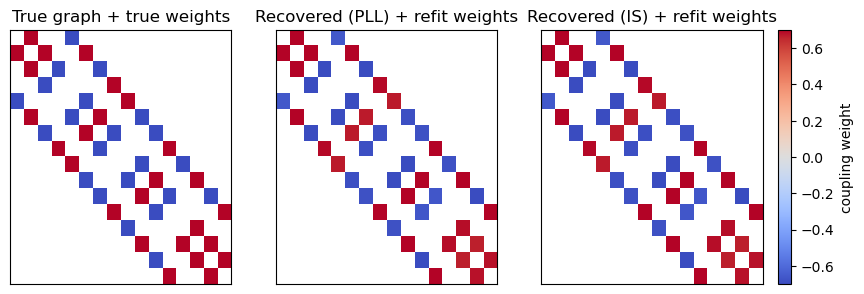

In [15]:
# --- Additional figure: recovered adjacency with signed edge weights (Stage-2 refit, no L1) ---
# This cell does NOT modify the recovery pipeline above; it only refits weights on the already recovered graphs
# (Ahat_pll and Ahat_is) and produces a richer visualization.

# Sanity checks: these should already exist from prior cells
for _name in ["X", "A_true", "Ahat_pll", "Ahat_is", "W_true"]:
    if _name not in globals():
        raise NameError(f"Expected variable '{_name}' to be defined before running this cell.")

# Refit (unpenalized) weights on the recovered graphs (same routine as used in the lambda-sweep helper)
W_pll_refit_plot, b_pll_refit_plot, _ = refit_weights_given_graph_pll(X, Ahat_pll, max_iter=650, step=0.25)
W_is_refit_plot,  b_is_refit_plot,  _ = refit_weights_given_graph_pll(X, Ahat_is,  max_iter=650, step=0.25)

def symmetrize_weights(W):
    return 0.5*(W + W.T)

def masked_by_adjacency(Wsym, A):
    M = Wsym.copy().astype(float)
    M[A == 0] = np.nan
    np.fill_diagonal(M, np.nan)
    return M

Wsym_true = symmetrize_weights(W_true)
Wsym_pll  = symmetrize_weights(W_pll_refit_plot)
Wsym_is   = symmetrize_weights(W_is_refit_plot)

M_true = masked_by_adjacency(Wsym_true, A_true)
M_pll  = masked_by_adjacency(Wsym_pll,  Ahat_pll)
M_is   = masked_by_adjacency(Wsym_is,   Ahat_is)

# Shared scale for comparability (use true weights)
vmax = np.nanmax(np.abs(M_true))
if not np.isfinite(vmax) or vmax <= 0:
    vmax = np.nanmax(np.abs(np.concatenate([np.ravel(M_pll[~np.isnan(M_pll)]), np.ravel(M_is[~np.isnan(M_is)])])))
vmax = float(vmax) if np.isfinite(vmax) else 1.0

plt.figure(figsize=(10.2, 3.3))

ax1 = plt.subplot(1,3,1)
im1 = ax1.imshow(M_true, aspect="auto", vmin=-vmax, vmax=vmax, cmap="coolwarm")
ax1.set_title("True graph + true weights")
ax1.set_xticks([]); ax1.set_yticks([])

ax2 = plt.subplot(1,3,2)
im2 = ax2.imshow(M_pll, aspect="auto", vmin=-vmax, vmax=vmax, cmap="coolwarm")
ax2.set_title("Recovered (PLL) + refit weights")
ax2.set_xticks([]); ax2.set_yticks([])

ax3 = plt.subplot(1,3,3)
im3 = ax3.imshow(M_is, aspect="auto", vmin=-vmax, vmax=vmax, cmap="coolwarm")
ax3.set_title("Recovered (IS) + refit weights")
ax3.set_xticks([]); ax3.set_yticks([])

plt.colorbar(im3, ax=[ax1, ax2, ax3], fraction=0.028, pad=0.02, label="coupling weight")
savefig("ising_adj_true_pll_is_weighted_edges.png")
plt.show()

saved: figs/ising_adj_true_pll_is_weighted_edges_rgba.png


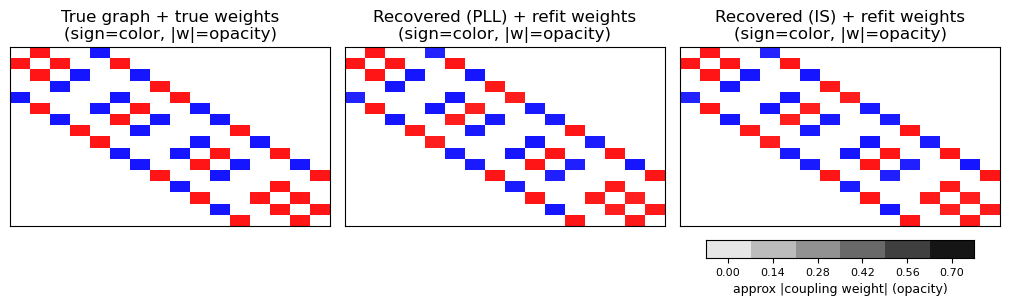

In [16]:
# --- Additional figure (recommended): sign-by-hue + magnitude-by-opacity (Stage-2 refit, no L1) ---
# This cell does NOT modify the recovery pipeline above; it only refits weights on the already recovered graphs
# (Ahat_pll and Ahat_is) and produces a richer visualization where:
#   - red = positive coupling, blue = negative coupling
#   - opacity ~ |coupling|
#   - white = no edge

# Sanity checks: these should already exist from prior cells
for _name in ["X", "A_true", "Ahat_pll", "Ahat_is", "W_true"]:
    if _name not in globals():
        raise NameError(f"Expected variable '{_name}' to be defined before running this cell.")

# Refit (unpenalized) weights on the recovered graphs (same routine as used earlier)
W_pll_refit_plot, b_pll_refit_plot, _ = refit_weights_given_graph_pll(X, Ahat_pll, max_iter=650, step=0.25)
W_is_refit_plot,  b_is_refit_plot,  _ = refit_weights_given_graph_pll(X, Ahat_is,  max_iter=650, step=0.25)

def symmetrize_weights(W):
    return 0.5 * (W + W.T)

def mask_weights(Wsym, A):
    """Return a dense matrix where only edges are kept; non-edges and diagonal are set to 0."""
    M = Wsym.copy().astype(float)
    M[A == 0] = 0.0
    np.fill_diagonal(M, 0.0)
    return M

Wsym_true = symmetrize_weights(W_true)
Wsym_pll  = symmetrize_weights(W_pll_refit_plot)
Wsym_is   = symmetrize_weights(W_is_refit_plot)

M_true = mask_weights(Wsym_true, A_true)
M_pll  = mask_weights(Wsym_pll,  Ahat_pll)
M_is   = mask_weights(Wsym_is,   Ahat_is)

# Shared scale for comparability (prefer true weights)
vmax = np.max(np.abs(M_true))
if not np.isfinite(vmax) or vmax <= 0:
    vmax = np.max(np.abs(np.concatenate([M_pll.ravel(), M_is.ravel()])))
vmax = float(vmax) if np.isfinite(vmax) and vmax > 0 else 1.0

def rgba_sign_magnitude(M, vmax, alpha_max=0.92, alpha_min=0.10):
    """
    Encode sign in color (red/blue) and magnitude in opacity.
    Non-edges (zeros) are white with alpha=0.
    """
    N = M.shape[0]
    rgba = np.ones((N, N, 4), dtype=float)  # start from white background
    rgba[..., 3] = 0.0                      # fully transparent by default (so background is white)

    mag = np.abs(M) / (vmax + 1e-12)
    mag = np.clip(mag, 0.0, 1.0)

    # edges are where magnitude > 0
    mask = mag > 0
    # opacity ramps with magnitude; keep small edges visible but not overpowering
    alpha = alpha_min + (alpha_max - alpha_min) * mag

    # red for positive, blue for negative
    pos = (M > 0) & mask
    neg = (M < 0) & mask

    rgba[..., 0][pos] = 1.0  # red channel
    rgba[..., 1][pos] = 0.0
    rgba[..., 2][pos] = 0.0

    rgba[..., 0][neg] = 0.0
    rgba[..., 1][neg] = 0.0
    rgba[..., 2][neg] = 1.0  # blue channel

    rgba[..., 3][mask] = alpha[mask]
    return rgba

RGBA_true = rgba_sign_magnitude(M_true, vmax)
RGBA_pll  = rgba_sign_magnitude(M_pll,  vmax)
RGBA_is   = rgba_sign_magnitude(M_is,   vmax)

plt.figure(figsize=(10.2, 3.3))

ax1 = plt.subplot(1,3,1)
ax1.imshow(RGBA_true, aspect="auto", interpolation="nearest")
ax1.set_title("True graph + true weights\n(sign=color, |w|=opacity)")
ax1.set_xticks([]); ax1.set_yticks([])

ax2 = plt.subplot(1,3,2)
ax2.imshow(RGBA_pll, aspect="auto", interpolation="nearest")
ax2.set_title("Recovered (PLL) + refit weights\n(sign=color, |w|=opacity)")
ax2.set_xticks([]); ax2.set_yticks([])

ax3 = plt.subplot(1,3,3)
ax3.imshow(RGBA_is, aspect="auto", interpolation="nearest")
ax3.set_title("Recovered (IS) + refit weights\n(sign=color, |w|=opacity)")
ax3.set_xticks([]); ax3.set_yticks([])

# Add a simple magnitude legend (opacity ramp) as an inset on the last axis
# (keeps the figure self-explanatory without relying on a standard colorbar)
legend_vals = np.linspace(0, 1, 6)
legend_img = np.zeros((1, legend_vals.size, 4), dtype=float)
legend_img[..., 3] = 0.10 + (0.92 - 0.10) * legend_vals  # same alpha mapping
legend_img[..., 0] = 0.0
legend_img[..., 2] = 0.0
legend_img[..., 1] = 0.0  # black ramp for visibility
inset = ax3.inset_axes([0.08, -0.18, 0.84, 0.10])
inset.imshow(legend_img, aspect="auto", interpolation="nearest")
inset.set_xticks(range(legend_vals.size))
inset.set_xticklabels([f"{vmax*v:.2f}" for v in legend_vals], fontsize=8)
inset.set_yticks([])
inset.set_xlabel("approx |coupling weight| (opacity)", fontsize=9)

plt.tight_layout()
savefig("ising_adj_true_pll_is_weighted_edges_rgba.png")
plt.show()

/var/folders/s5/8pby83n5305c0l0dvb7d7p5c0000gr/T/ipykernel_72562/3665398835.py:86: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


saved: figs/ising_adj_true_pll_is_weighted_edges_seismic.png


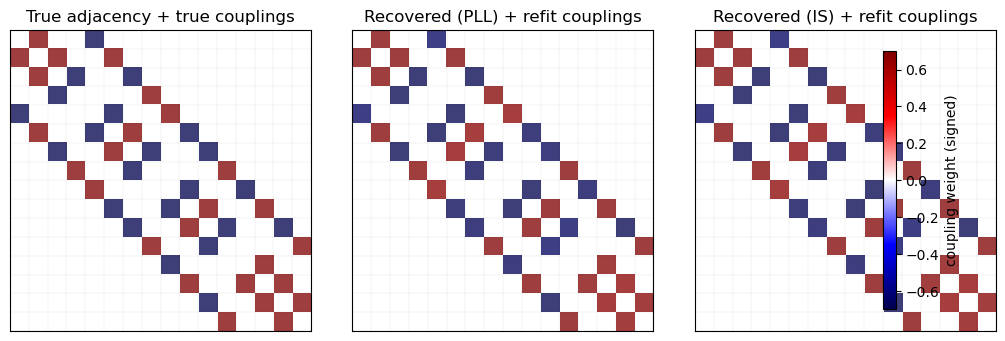

In [17]:
# --- Additional figure: recovered adjacency with signed edge weights (Stage-2 refit, no L1) ---
# This cell does NOT modify the recovery pipeline above; it only refits weights on the already recovered graphs
# (Ahat_pll and Ahat_is) and produces a richer visualization with a proper colorbar.

from matplotlib.colors import TwoSlopeNorm

# Sanity checks: these should already exist from prior cells
for _name in ["X", "A_true", "Ahat_pll", "Ahat_is", "W_true"]:
    if _name not in globals():
        raise NameError(f"Expected variable '{_name}' to be defined before running this cell.")

# Refit (unpenalized) weights on the recovered graphs (same routine as used elsewhere)
W_pll_refit_plot, b_pll_refit_plot, _ = refit_weights_given_graph_pll(X, Ahat_pll, max_iter=650, step=0.25)
W_is_refit_plot,  b_is_refit_plot,  _ = refit_weights_given_graph_pll(X, Ahat_is,  max_iter=650, step=0.25)

def symmetrize_weights(W):
    return 0.5 * (W + W.T)

def masked_by_adjacency(Wsym, A):
    """Keep only edges, everything else NaN (so it renders as white)."""
    M = Wsym.copy().astype(float)
    M[A == 0] = np.nan
    np.fill_diagonal(M, np.nan)
    return M

Wsym_true = symmetrize_weights(W_true)
Wsym_pll  = symmetrize_weights(W_pll_refit_plot)
Wsym_is   = symmetrize_weights(W_is_refit_plot)

M_true = masked_by_adjacency(Wsym_true, A_true)
M_pll  = masked_by_adjacency(Wsym_pll,  Ahat_pll)
M_is   = masked_by_adjacency(Wsym_is,   Ahat_is)

# Shared scale for comparability (prefer true weights; fallback to recovered)
vmax = np.nanmax(np.abs(M_true))
if not np.isfinite(vmax) or vmax <= 0:
    vmax = np.nanmax(np.abs(np.concatenate([
        M_pll[~np.isnan(M_pll)].ravel(),
        M_is[~np.isnan(M_is)].ravel()
    ])))
vmax = float(vmax) if np.isfinite(vmax) and vmax > 0 else 1.0

# Strong diverging colormap + white for NaNs
cmap = plt.get_cmap("seismic").copy()   # more saturated than coolwarm
cmap.set_bad(color="white")             # NaNs show as white

norm = TwoSlopeNorm(vmin=-vmax, vcenter=0.0, vmax=vmax)

def overlay_edge_outline(ax, A, lw=0.35):
    """Optional: draw a thin outline over present edges to emphasize the graph structure."""
    # Build a mask image: 1 on edges, NaN elsewhere
    O = A.astype(float).copy()
    np.fill_diagonal(O, np.nan)
    O[O == 0] = np.nan
    ax.imshow(O, cmap="gray", vmin=0, vmax=1, interpolation="nearest", alpha=0.25)
    # Add a subtle grid-like outline by drawing minor ticks
    N = A.shape[0]
    ax.set_xticks(np.arange(-.5, N, 1), minor=True)
    ax.set_yticks(np.arange(-.5, N, 1), minor=True)
    ax.grid(which="minor", color="black", linestyle="-", linewidth=lw, alpha=0.10)
    ax.tick_params(which="minor", bottom=False, left=False)

plt.figure(figsize=(10.4, 3.35))

ax1 = plt.subplot(1,3,1)
im1 = ax1.imshow(M_true, aspect="auto", cmap=cmap, norm=norm, interpolation="nearest")
ax1.set_title("True adjacency + true couplings")
ax1.set_xticks([]); ax1.set_yticks([])
overlay_edge_outline(ax1, A_true)

ax2 = plt.subplot(1,3,2)
im2 = ax2.imshow(M_pll, aspect="auto", cmap=cmap, norm=norm, interpolation="nearest")
ax2.set_title("Recovered (PLL) + refit couplings")
ax2.set_xticks([]); ax2.set_yticks([])
overlay_edge_outline(ax2, Ahat_pll)

ax3 = plt.subplot(1,3,3)
im3 = ax3.imshow(M_is, aspect="auto", cmap=cmap, norm=norm, interpolation="nearest")
ax3.set_title("Recovered (IS) + refit couplings")
ax3.set_xticks([]); ax3.set_yticks([])
overlay_edge_outline(ax3, Ahat_is)

cbar = plt.colorbar(im3, ax=[ax1, ax2, ax3], fraction=0.030, pad=0.02)
cbar.set_label("coupling weight (signed)", rotation=90)

plt.tight_layout()
savefig("ising_adj_true_pll_is_weighted_edges_seismic.png")
plt.show()


saved: figs/ising_adj_true_pll_is_dev_from_truth.png


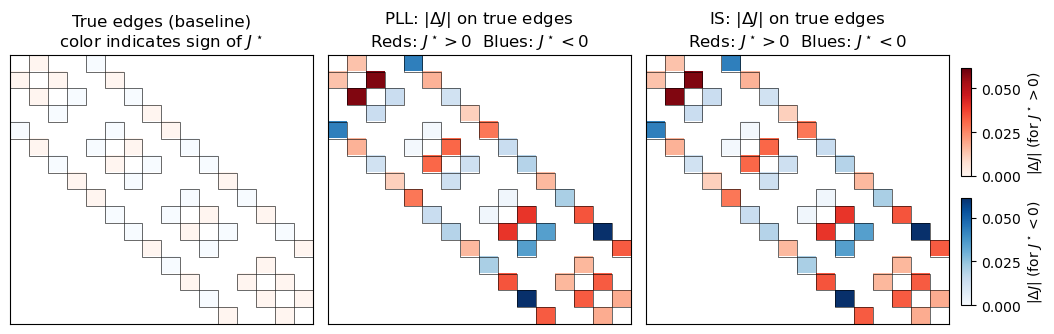

In [18]:
# --- Additional figure: deviations from ground-truth couplings (+0.35 / -0.35), with sign-specific color coding ---
# This cell does NOT modify the recovery pipeline above; it only refits weights on already recovered graphs
# and visualizes ΔJ = J_hat - J_true on edges.
#
# Color scheme:
#   - edges with true J>0: Reds intensity ~ |ΔJ|
#   - edges with true J<0: Blues intensity ~ |ΔJ|
#   - non-edges: white
#   - black envelopes outline true edges (A_true)

from matplotlib import patches

# Sanity checks
for _name in ["X", "A_true", "Ahat_pll", "Ahat_is", "W_true"]:
    if _name not in globals():
        raise NameError(f"Expected variable '{_name}' to be defined before running this cell.")

# Refit (unpenalized) weights on the recovered graphs (same routine used earlier)
W_pll_refit_plot, b_pll_refit_plot, _ = refit_weights_given_graph_pll(X, Ahat_pll, max_iter=650, step=0.25)
W_is_refit_plot,  b_is_refit_plot,  _ = refit_weights_given_graph_pll(X, Ahat_is,  max_iter=650, step=0.25)

def symmetrize_weights(W):
    return 0.5 * (W + W.T)

Wsym_true = symmetrize_weights(W_true)
Wsym_pll  = symmetrize_weights(W_pll_refit_plot)
Wsym_is   = symmetrize_weights(W_is_refit_plot)

# Compute deviations on edges
D_pll = Wsym_pll - Wsym_true
D_is  = Wsym_is  - Wsym_true

# We will visualize deviations only on TRUE edges (Bars-and-Stripes-like setting assumes known ±J levels)
edge_mask = (A_true == 1)
np.fill_diagonal(edge_mask, False)

# Split deviations by sign of the TRUE coupling
pos_true = edge_mask & (Wsym_true > 0)
neg_true = edge_mask & (Wsym_true < 0)

def rgba_deviation(D, pos_true, neg_true, vmax):
    """
    Build an RGBA image:
      - pos_true edges: Reds(|Δ|)
      - neg_true edges: Blues(|Δ|)
      - non-edges: white
    """
    N = D.shape[0]
    rgba = np.ones((N, N, 4), dtype=float)   # white background
    rgba[..., 3] = 1.0

    # Normalize magnitude
    mag = np.abs(D) / (vmax + 1e-12)
    mag = np.clip(mag, 0.0, 1.0)

    # Fetch colormaps
    reds = plt.get_cmap("Reds")
    blues = plt.get_cmap("Blues")

    # Apply to pos_true edges
    if np.any(pos_true):
        rgba[pos_true] = reds(mag[pos_true])
        rgba[pos_true, 3] = 1.0

    # Apply to neg_true edges
    if np.any(neg_true):
        rgba[neg_true] = blues(mag[neg_true])
        rgba[neg_true, 3] = 1.0

    # Non-edges remain white (already)
    return rgba

# Choose scale from max deviation across both recovered methods on true edges
vmax = 0.0
if np.any(edge_mask):
    vmax = max(vmax, float(np.max(np.abs(D_pll[edge_mask]))))
    vmax = max(vmax, float(np.max(np.abs(D_is[edge_mask]))))
if not np.isfinite(vmax) or vmax <= 0:
    vmax = 1e-3  # safe fallback

RGBA_pll = rgba_deviation(D_pll, pos_true, neg_true, vmax)
RGBA_is  = rgba_deviation(D_is,  pos_true, neg_true, vmax)

# A reference panel: show "zero deviation" baseline with sign-coded edges at 0 magnitude (very light)
D0 = np.zeros_like(Wsym_true)
RGBA_ref = rgba_deviation(D0, pos_true, neg_true, vmax)

def draw_edge_envelopes(ax, A, lw=0.6):
    """Draw black rectangles around cells where A[i,j]=1 (upper triangle only for neatness)."""
    N = A.shape[0]
    for i in range(N):
        for j in range(N):
            if i != j and A[i, j] == 1:
                # rectangle around cell (j,i) in imshow coordinates
                rect = patches.Rectangle((j-0.5, i-0.5), 1, 1, fill=False,
                                         edgecolor="black", linewidth=lw, alpha=0.75)
                ax.add_patch(rect)

plt.figure(figsize=(10.6, 3.45))

ax1 = plt.subplot(1,3,1)
ax1.imshow(RGBA_ref, aspect="auto", interpolation="nearest")
ax1.set_title("True edges (baseline)\ncolor indicates sign of $J^\\star$")
ax1.set_xticks([]); ax1.set_yticks([])
draw_edge_envelopes(ax1, A_true, lw=0.55)

ax2 = plt.subplot(1,3,2)
ax2.imshow(RGBA_pll, aspect="auto", interpolation="nearest")
ax2.set_title("PLL: $|\\Delta J|$ on true edges\nReds: $J^\\star>0$  Blues: $J^\\star<0$")
ax2.set_xticks([]); ax2.set_yticks([])
draw_edge_envelopes(ax2, A_true, lw=0.55)

ax3 = plt.subplot(1,3,3)
ax3.imshow(RGBA_is, aspect="auto", interpolation="nearest")
ax3.set_title("IS: $|\\Delta J|$ on true edges\nReds: $J^\\star>0$  Blues: $J^\\star<0$")
ax3.set_xticks([]); ax3.set_yticks([])
draw_edge_envelopes(ax3, A_true, lw=0.55)

# Two colorbars (one per colormap), both mapping |ΔJ| in [0, vmax]
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

norm = Normalize(vmin=0.0, vmax=vmax)
sm_red = ScalarMappable(norm=norm, cmap=plt.get_cmap("Reds"))
sm_blue = ScalarMappable(norm=norm, cmap=plt.get_cmap("Blues"))
sm_red.set_array([])
sm_blue.set_array([])

# Place colorbars on the right, stacked
cax1 = ax3.inset_axes([1.04, 0.55, 0.035, 0.40])  # [x0,y0,w,h] in axes fraction
cax2 = ax3.inset_axes([1.04, 0.07, 0.035, 0.40])

cb1 = plt.colorbar(sm_red, cax=cax1)
cb1.set_label(r"$|\Delta J|$ (for $J^\star>0$)", rotation=90)

cb2 = plt.colorbar(sm_blue, cax=cax2)
cb2.set_label(r"$|\Delta J|$ (for $J^\star<0$)", rotation=90)

plt.tight_layout()
savefig("ising_adj_true_pll_is_dev_from_truth.png")
plt.show()
